#Importing Libraries

In [ ]:
#import all necessary libraries
import numpy as np
import pandas as pd
from numpy import load
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.metrics import Accuracy, Precision, Recall
from tensorflow.keras import layers, models
from matplotlib import pyplot as plt
from keras.layers import BatchNormalization
import keras
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
! pip install -q focal-loss
! pip install -q streamlit
! pip install -q pyngrok

     |████████████████████████████████| 9.7 MB 4.8 MB/s 
     |████████████████████████████████| 164 kB 12.7 MB/s 
     |████████████████████████████████| 76 kB 1.8 MB/s 
     |████████████████████████████████| 111 kB 41.2 MB/s 
     |████████████████████████████████| 180 kB 36.6 MB/s 
     |████████████████████████████████| 4.3 MB 35.0 MB/s 
     |████████████████████████████████| 63 kB 1.6 MB/s 
     |████████████████████████████████| 128 kB 51.0 MB/s 
     |████████████████████████████████| 792 kB 37.7 MB/s 
     |████████████████████████████████| 375 kB 37.3 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jupyter-console 5.2.0 requires prompt-toolkit<2.0.0,>=1.0.0, but you have prompt-toolkit 3.0.26 which is incompatible.
google-colab 1.0.0 requires ipykernel~=4.10, but you have ipykernel 6.8.0 which is incompatible.
google-colab 1.0.0 requires ipytho

In [ ]:
from focal_loss import SparseCategoricalFocalLoss

#Loading the Data

In [ ]:
#mount google drive to import dataset stored in the drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = load('/content/drive/MyDrive/dermamnist.npz')
print(data.files)

['train_images', 'val_images', 'test_images', 'train_labels', 'val_labels', 'test_labels']


In [ ]:
#dataset is split up into training, validation and testing sets respectively for X and Y
X_train, y_train = data['train_images'], data['train_labels']
X_val, y_val = data['val_images'], data['val_labels']
X_test, y_test = data['test_images'], data['test_labels']

print("Train dataset:        ", X_train.shape, y_train.shape)
print("Validation dataset:   ", X_val.shape, y_val.shape)
print("Test dataset:         ", X_test.shape, y_test.shape)

Train dataset:         (7007, 28, 28, 3) (7007, 1)
Validation dataset:    (1003, 28, 28, 3) (1003, 1)
Test dataset:          (2005, 28, 28, 3) (2005, 1)


In [ ]:
X = np.concatenate((X_train, X_val, X_test), axis=0)
y = np.concatenate((y_train, y_val, y_test), axis=0)

In [ ]:
y_train, y_val, y_test = y_train.reshape(-1), y_val.reshape(-1), y_test.reshape(-1)

print(y_val.shape, y_test.shape, y_train.shape)
X_val.shape, X_test.shape, X_train.shape

(1003,) (2005,) (7007,)


((1003, 28, 28, 3), (2005, 28, 28, 3), (7007, 28, 28, 3))

In [ ]:
#sclae the data so that the DL network can work efficiently
X_val, X_test, X_train = X_val/255, X_test/255, X_train/255

#EDA Visualization

In [ ]:
#check the classes
np.unique(data['test_labels'])

array([0, 1, 2, 3, 4, 5, 6], dtype=uint8)

In [ ]:
labels = ['akiec',
          'bcc',
          'bkl',
          'df',
          'nv',
          'vasc',
          'mel']

In [ ]:
classes = []
for i in range(len(labels)):
  classes.append(len(np.where(y==i)[0]))

classes_df = pd.DataFrame(classes,index=labels, columns = ['Count'])

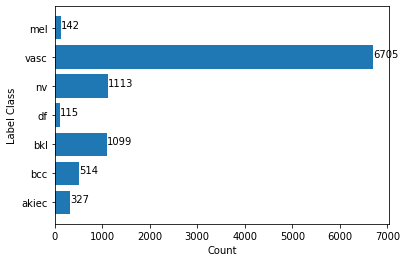

In [ ]:
#visualize the distribution of the images in the dataset according to classes
x = classes_df.index
y = classes_df.Count
plt.barh(x, y)
plt.xlabel('Count')
plt.ylabel('Label Class')
for index, value in enumerate(y):
    plt.text(value, index,
             str(value))
plt.show()

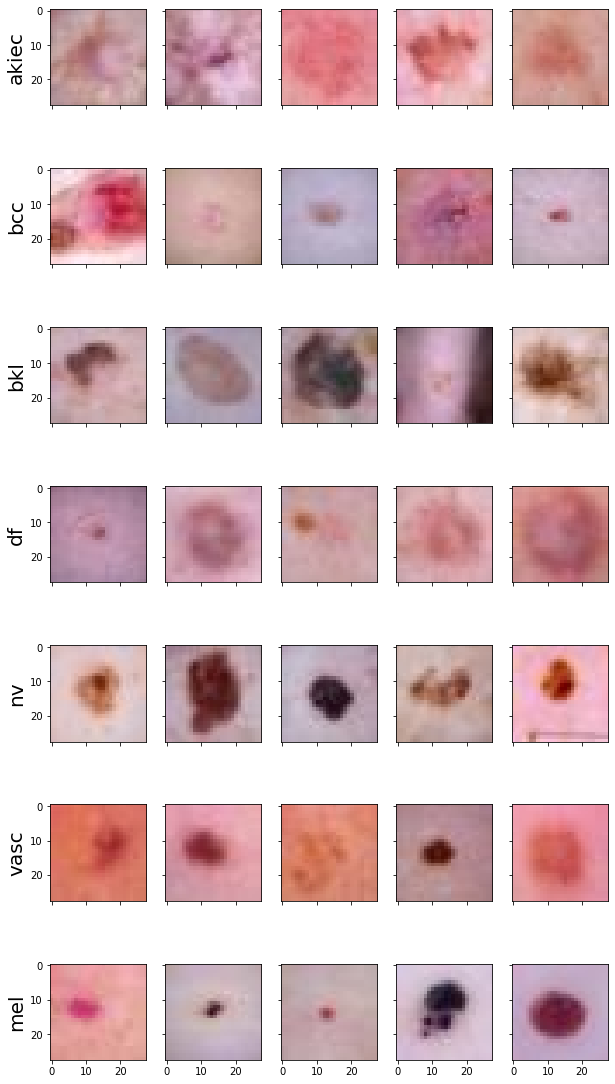

In [ ]:
#get an overview of the images that we would be dealing with by viewing them in a grid divided by classes
fig, ax = plt.subplots(7, 5)
fig.set_figheight(20)
fig.set_figwidth(10)
for classes in range (7):
  for i, inx in enumerate(np.where(y_train==classes)[0][:5]):
    ax[classes,i].imshow(X_train[inx])
    ax[classes,i].set_ylabel(labels[classes],fontsize = 20.0)
    ax[classes,i].label_outer()

#Model Creation & Training

In [ ]:
#create a sequential model with different types of layers and activation function
model = models.Sequential()

model.add(layers.Conv2D(16, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(28,28,3)))
model.add(layers.Conv2D(16, kernel_size=(3, 3), activation='relu', padding='same' ))
model.add(BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(layers.Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.25))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.25))

model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.25))

model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.25))

model.add(layers.Dense(7, activation='softmax'))

In [ ]:
#select the hyperparameters that would be used to train the model
batch_size = 128
no_epochs = 300
learn_rate = 0.00013

In [ ]:
#select the optimizer for the model. Adam is a replacement optimization algorithm for stochastic gradient descent for training deep learning models.
from tensorflow.keras.optimizers import Adam
my_optimizer=Adam(lr=learn_rate)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
#view the summary of the model created
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 16)        448       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 16)        2320      
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 16)       64        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 16)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 14, 14, 16)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 32)        4

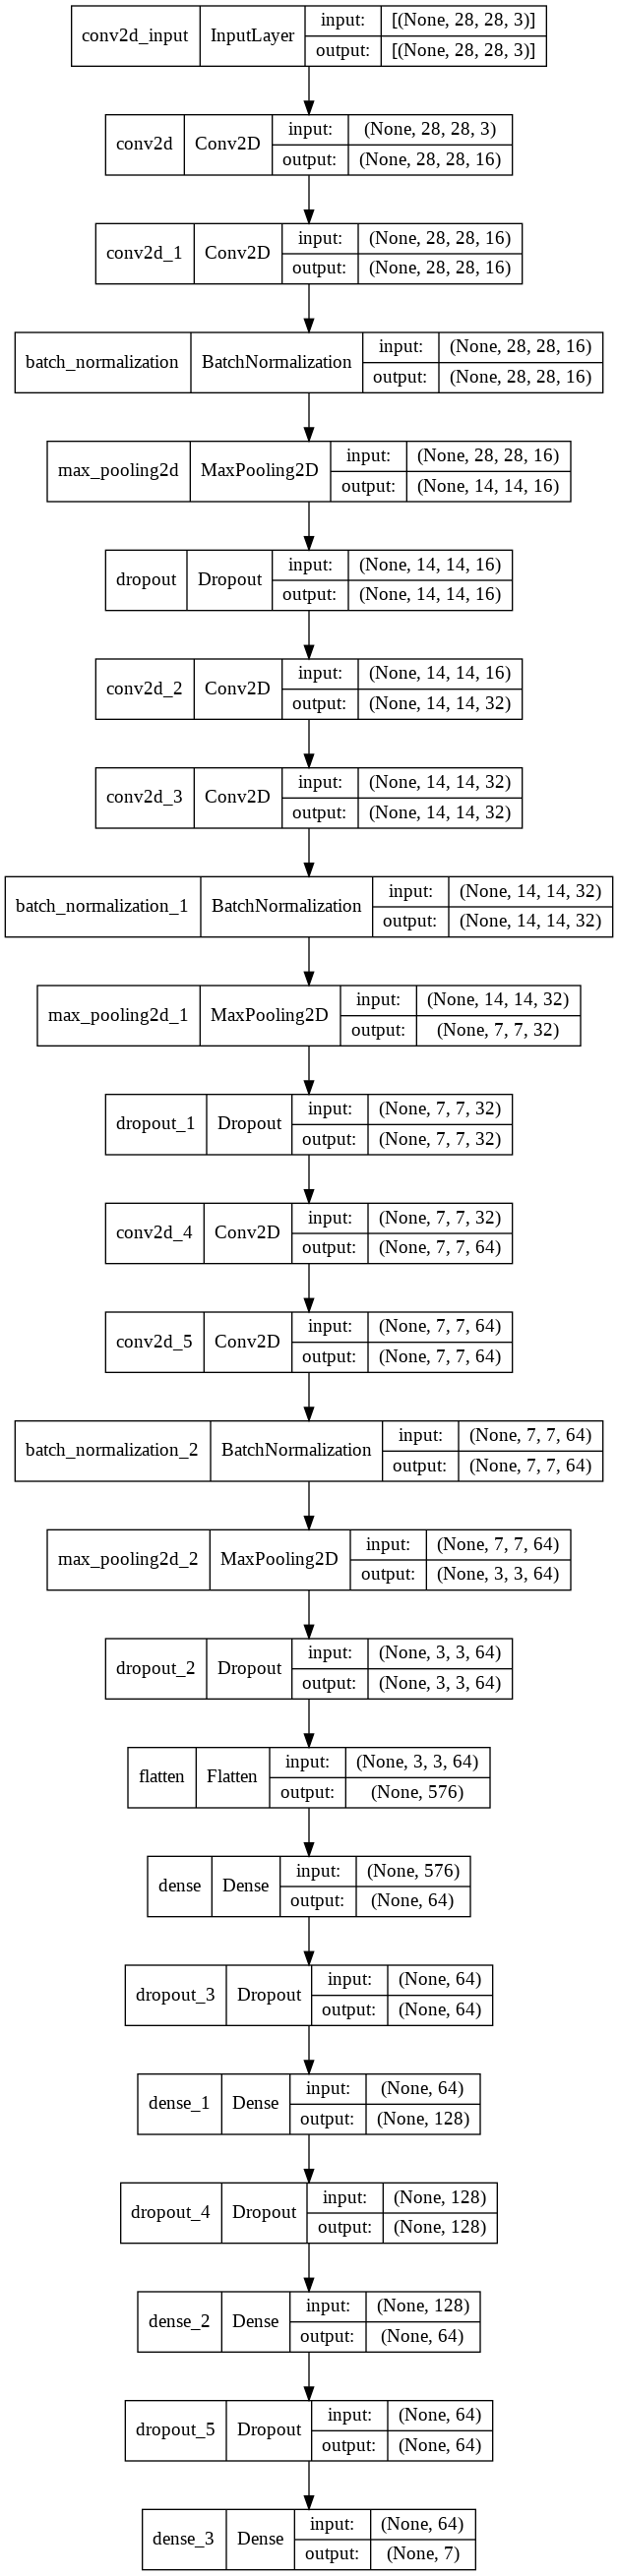

In [ ]:
#visualize the model created with layer flow
tf.keras.utils.plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
#define a class that would be used to stop the model training when we reach a certain rate of validation accuracy
class StopOnPoint(tf.keras.callbacks.Callback):
    def __init__(self, point):
        super(StopOnPoint, self).__init__()
        self.point = point

    def on_epoch_end(self, epoch, logs=None): 
        accuracy = logs["val_accuracy"]
        if accuracy >= self.point:
            self.model.stop_training = True
            
#set the stopping accuracy to 0.78 (which is the highest seen accuracy during training of the model)
callbacks = [StopOnPoint(0.78)] # <- set optimal point

In [ ]:
#compile the model with Focal Loss function - gamma = 2
model.compile(loss=SparseCategoricalFocalLoss(gamma=2),
              optimizer=my_optimizer,
              metrics=['accuracy'])

In [ ]:
#fit the model with stopping function defined before
summary = model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=no_epochs,
          verbose=1,
          validation_data=(X_val, y_val),
          callbacks=[callbacks])

Epoch 1/300
55/55 [==============================] - 17s 54ms/step - loss: 1.1349 - accuracy: 0.4798 - val_loss: 1.3358 - val_accuracy: 0.1097
Epoch 2/300
55/55 [==============================] - 2s 30ms/step - loss: 0.7663 - accuracy: 0.6098 - val_loss: 1.1596 - val_accuracy: 0.1097
Epoch 3/300
55/55 [==============================] - 2s 33ms/step - loss: 0.7133 - accuracy: 0.6277 - val_loss: 1.0088 - val_accuracy: 0.1206
Epoch 4/300
55/55 [==============================] - 2s 31ms/step - loss: 0.6871 - accuracy: 0.6368 - val_loss: 0.9720 - val_accuracy: 0.1147
Epoch 5/300
55/55 [==============================] - 1s 26ms/step - loss: 0.6690 - accuracy: 0.6449 - val_loss: 0.9808 - val_accuracy: 0.1196
Epoch 6/300
55/55 [==============================] - 1s 25ms/step - loss: 0.6537 - accuracy: 0.6399 - val_loss: 0.9704 - val_accuracy: 0.1535
Epoch 7/300
55/55 [==============================] - 1s 25ms/step - loss: 0.6323 - accuracy: 0.6506 - val_loss: 0.9249 - val_accuracy: 0.3131
Epoch

In [ ]:
#save the model to our drive
tf.keras.models.save_model(model,'SkinSavior_model.hdf5')

#Model Evaluation

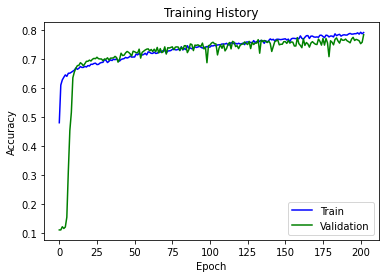

In [ ]:
#visualize the training vs the validation accuracy of the model
plt.plot(summary.history['accuracy'], c="b")
plt.plot(summary.history['val_accuracy'], c="g")
plt.title('Training History')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

In [ ]:
#check the testing loss and accuracy
score = model.evaluate(X_test, y_test, verbose=0)
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

Test loss: 0.3894684612751007 / Test accuracy: 0.7600997686386108


Classification report showing precision, recall and F1 score of all classes with overall accuracy

In [ ]:
y_pred = model.predict(X_test)
y_pred_classes = [np.argmax(element) for element in y_pred]
print(classification_report(y_test, y_pred_classes))

              precision    recall  f1-score   support

           0       0.53      0.48      0.51        66
           1       0.51      0.49      0.50       103
           2       0.61      0.45      0.52       220
           3       0.41      0.39      0.40        23
           4       0.50      0.15      0.23       223
           5       0.82      0.96      0.88      1341
           6       0.70      0.66      0.68        29

    accuracy                           0.76      2005
   macro avg       0.58      0.51      0.53      2005
weighted avg       0.73      0.76      0.73      2005



#Web app deployement

In [ ]:
#This is the code that will be running in the background of the web app
%%writefile app.py
import streamlit as st
import tensorflow as tf
import streamlit as st
from focal_loss import SparseCategoricalFocalLoss

lesion_type_dict = {
    0: 'Actinic keratoses',
    1: 'Basal cell carcinoma',
    2: 'Benign keratosis-like lesions ',
    3: 'Dermatofibroma',
    4: 'Melanocytic nevi',
    5: 'Vascular lesions',
    6: 'Melanoma'
}

@st.cache(allow_output_mutation=True)
def load_model():
  #load the model that we had trained and saved
  model=tf.keras.models.load_model('/content/SkinSavior_model.hdf5', custom_objects={'focal_loss_fixed': SparseCategoricalFocalLoss(gamma=2)})
  return model
with st.spinner('Model is being loaded..'):
  model=load_model()

st.write("""
         # Skin Cancer Classification
         """
         )

#Allow use input of images type jpg and png
file = st.file_uploader("Please upload a skin lesion picture", type=["jpg", "png"])

import cv2
from PIL import Image, ImageOps
import numpy
st.set_option('deprecation.showfileUploaderEncoding', False)
def import_and_predict(image_data, model):
  #take user image and adjust parameters so that the model will accept it as an input
  size = (28,28)    
  image = ImageOps.fit(image_data, size, Image.ANTIALIAS)
  image = numpy.asarray(image)
  img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  img_reshape = img[numpy.newaxis,...]
  #get prediction of the image input
  prediction = model.predict(img_reshape)
  classes_x=numpy.argmax(prediction,axis=1)
  pred = lesion_type_dict[classes_x[0]]
  return pred, prediction
if file is None:
    st.text("Please upload an image file")
else:
    #display the picture and the results of the prediction
    image = Image.open(file)
    st.image(image, use_column_width=True)
    pred, predictions = import_and_predict(image, model)
    score = tf.nn.softmax(predictions[0])
    max_score = (100 * numpy.max(score))
    st.write('This image most likely belongs to the class ', pred, ' with a confidence of ', max_score)

In [ ]:
#establish a connection with ngrok via authentication code
!ngrok authtoken 24YJoEdqFaets62AhKfVdiKt9pX_56D2PZxCfjdRkmexm27kw

In [ ]:
#use streamlit to load and run the web app coded previously
!nohup streamlit run app.py &

In [ ]:
#establish a tunnel with ngrok to run the streamlit app in HTML browser
from pyngrok import ngrok
url=ngrok.connect(port=8501)
url

In [ ]:
#configure the port so that the app will be able to run
!streamlit run --server.port 80 app.py >/dev/null